# Interpolating Parameters

If parameters are changing significantly on dynamical timescales (e.g. mass transfer at pericenter on very eccentric orbits) you need a specialized numerical scheme to do that accurately.
However, there are many astrophysical settings where parameters change very slowly compared to all the dynamical timescales in the problem.
As long as this is the case and the changes are adiabatic, you can modify these parameters between calls to `sim.integrate` very flexibly and without loss of accuracy. 

In order to provide a machine-independent way to interpolate parameters at arbitrary times, which can be shared between the C and Python versions of the code, we have implemented an interpolator object. 
For example, say you want to interpolate stellar evolution data.
We show below how you can use the `Interpolator` structure to spline a discrete set of time-parameter values.

We begin by reading in mass and radius data of our Sun, starting roughly 4 million years before the tip of its red-giant branch (RGB), and separating them into time and value arrays. 
You can populate these arrays however you want, but we load two text files (one for stellar mass, the other for stellar radius), where the first column gives the time (e.g., the Sun's age), and the second column gives the corresponding value (mass or radius).

All values need to be in simulation units. If you're using AU, then your stellar radii should also be in AU.

In [1]:
import numpy as np

data = np.loadtxt('mesa2txt/m.txt') # return (N, 2) array
mtimes = data[:, 0]        # return only 1st col
masses = data[:, 1]        # return only 2nd col

data = np.loadtxt('mesa2txt/r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]         # data in Rsun units

# convert Rsun to AU
radii = np.zeros(Rsuns.size)
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047
    radii[i] += 0.15       # upshift

Next we set up the Sun-Earth system.

In [2]:
import rebound
import reboundx

M0 = 0.8645388227818771 # initial mass of star
R0 = 0.3833838293200158 # initial radius of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2               # use units of AU, yrs and solar masses
    sim.add(m=M0, r=R0, hash='Star')
    sim.add(a=1., hash='Earth')
    sim.collision = 'direct'         # check if RGB Sun engulfs Earth
    sim.integrator = 'whfast'
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

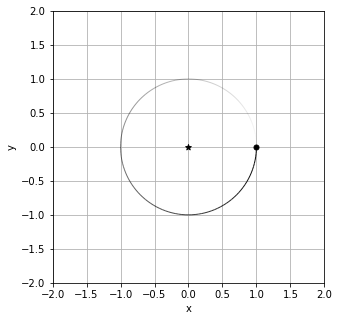

In [3]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [4]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')

Finally, we integrate for 4 Myr, updating the central body's mass and radius interpolated at the time between outputs. We then plot the resulting system:

CPU times: user 49.4 s, sys: 27.2 s, total: 1min 16s
Wall time: 1min 16s


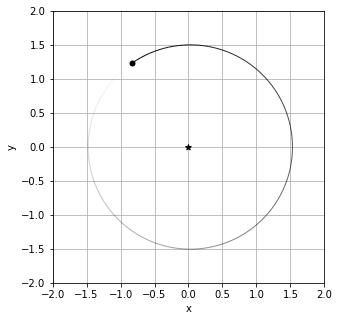

In [5]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros(Nout)
ts = np.linspace(0., 4.e6, Nout)
T0 = 1.23895e10 # Sun's age at simulation start

for i, time in enumerate(ts):
    sim.integrate(time)
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t)
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com() # lost mass had momentum, so need to move back to COM frame
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    a[i] = sim.particles[1].a
    
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.grid()

We see that, as the Sun loses mass along its RGB phase, the Earth has correspondingly and adiabatically expanded, as one might expect. Let's now plot the Sun's mass over time, and a comparison of the Sun's radius and Earth's semi-major axis over time, adjacent to one another.

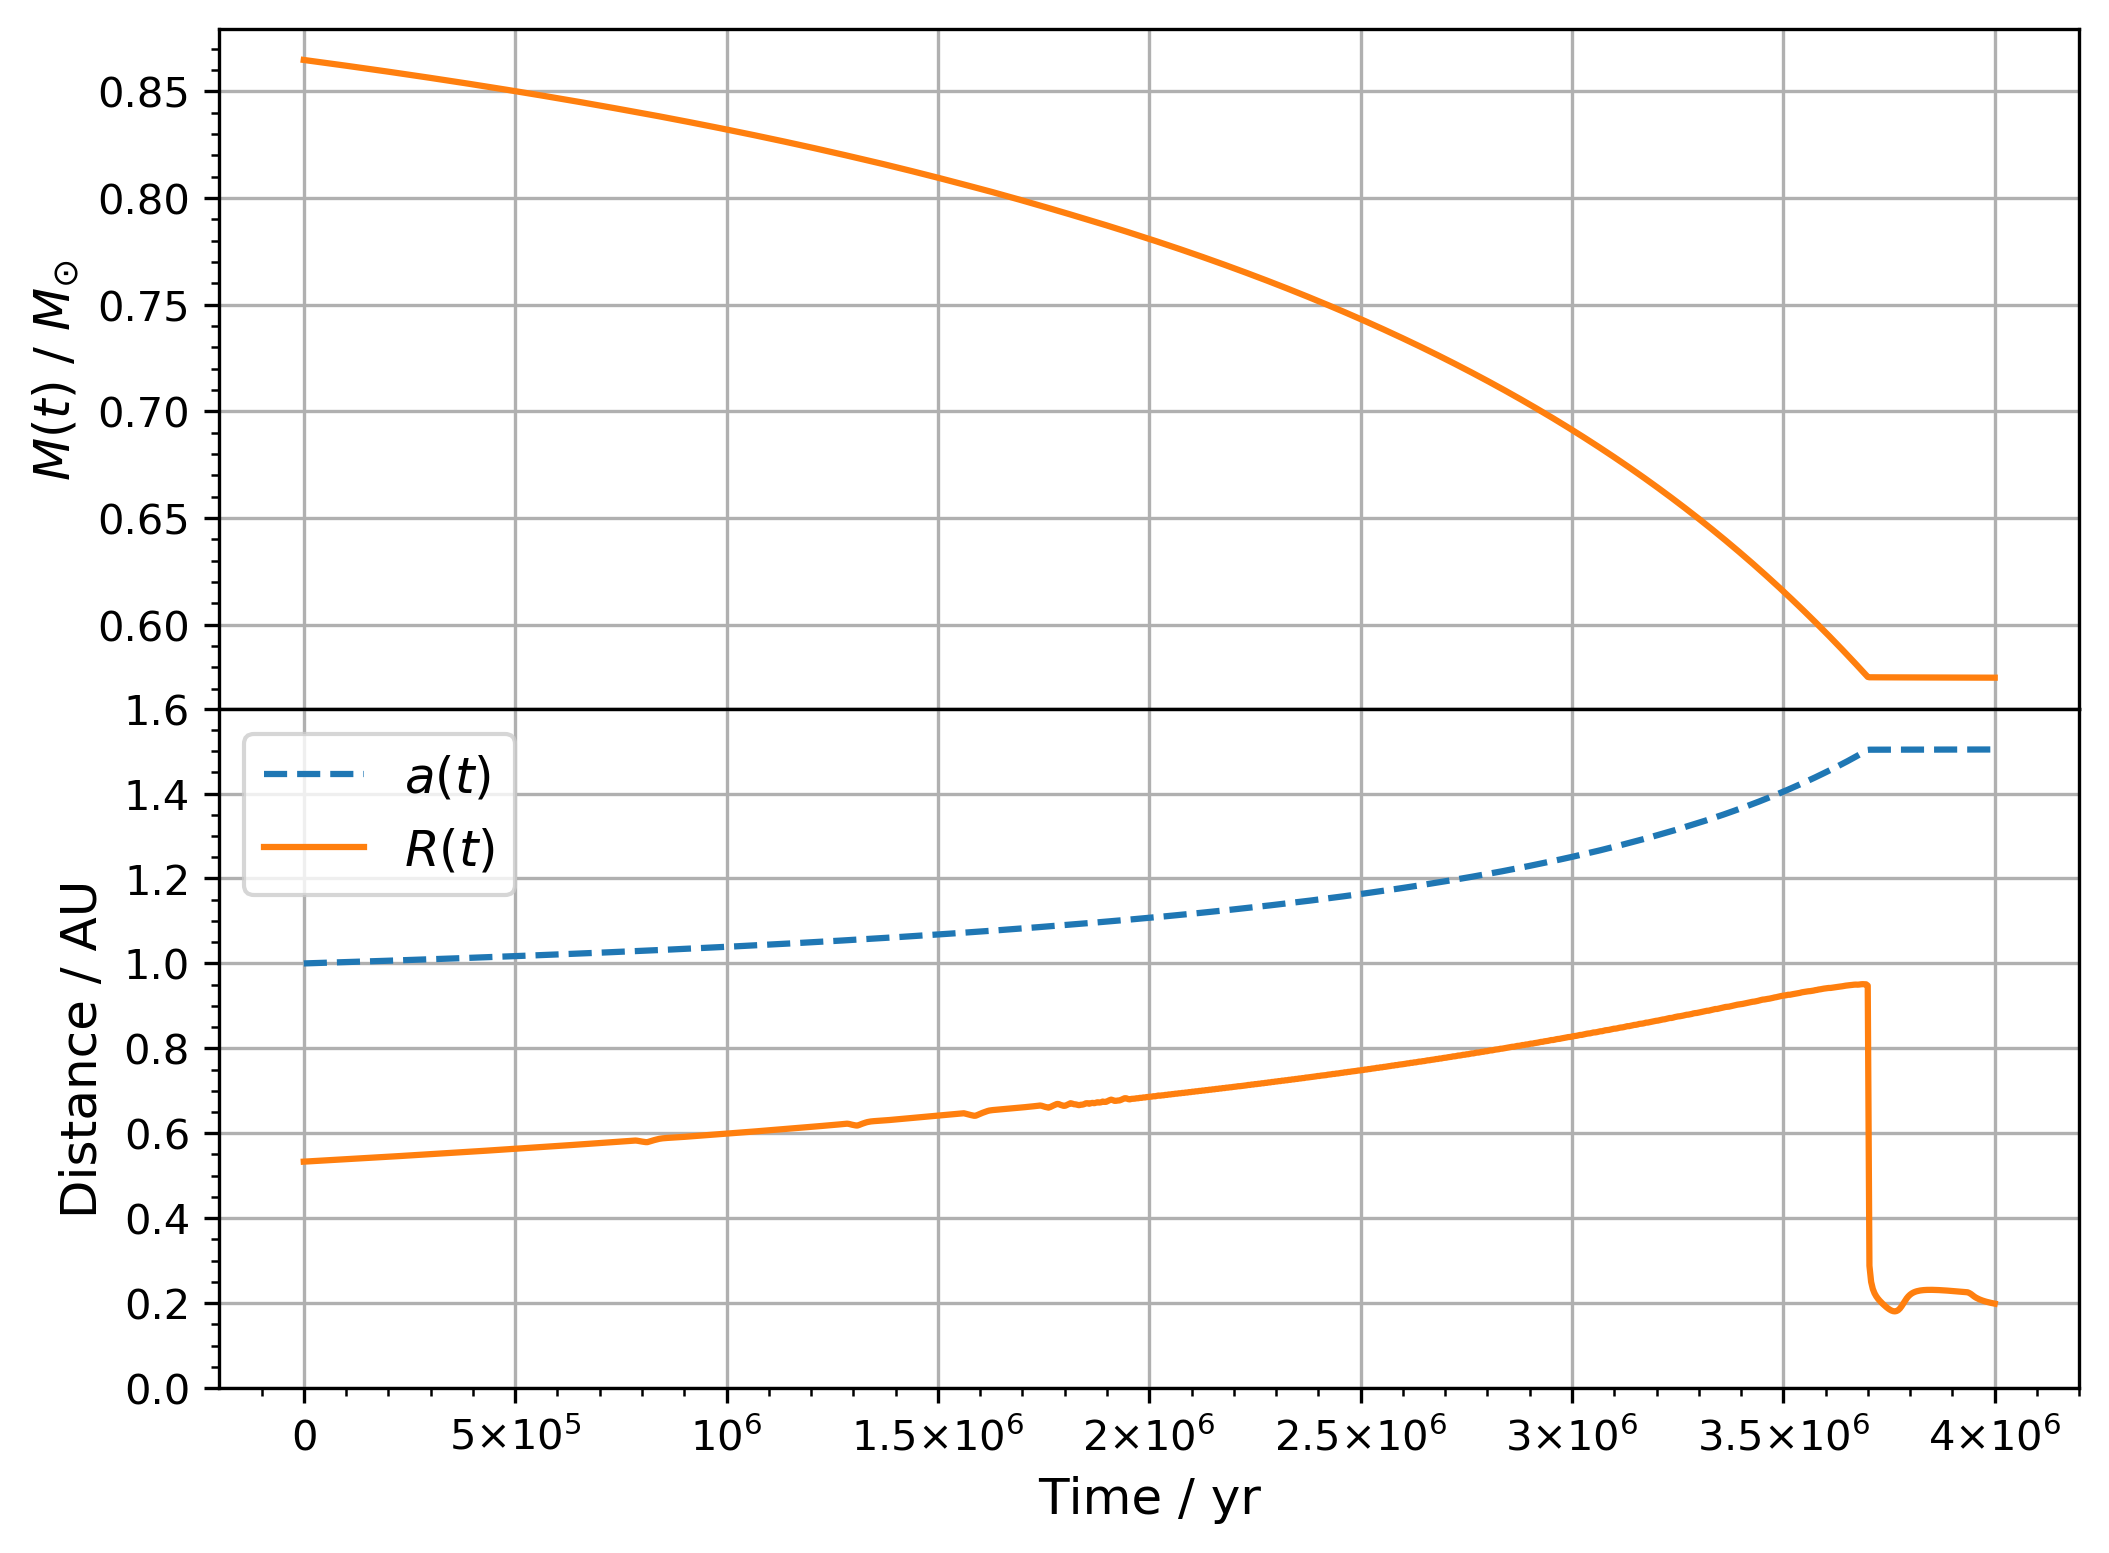

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts,mass, color='tab:orange')
ax1.grid()

ax2.set_xlabel('Time / yr', fontsize='large')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.set_ylim([0, 1.6])
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(ts,a, '--', label='$a(t)$')
ax2.plot(ts,radius, label='$R(t)$')
ax2.legend(fontsize='large', loc='upper left')
ax2.grid()

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('plots/expansion.png')